In [213]:
## DATA TYPES IN VISSIM
#
# Containers   : Contain all objects from a given class present in the model
#                Removing an item from a container removes it from collections and deletes it.
#
# Single Object: Stored in containers, can be interacted with directly.
#
# Collections  : Subsets of the containers, they store pointers.
#                Removing an item from a container does not remove it from the model.

In [214]:
%matplotlib inline

# Libraries
import win32com.client as com
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [215]:
# Model Parameters
Random_Seed = 42
model_name  = 'Single_Cross_Straight'
program = 'Q'
reward_type = 'Delay'
state_type  = 'Queues' 
simulation_length = 360000
Queue_Tracking = True
Start_Fresh = True

# RL Paramenters
alpha   = 0.9
gamma   = 0.3
epsilon = 0.1

In [216]:
## Connecting the COM Server => Open a new Vissim Window:
try:
    cache_flag
    print 'Checking Presence of Pregenerated Cache'
except:
    print 'Cache NOT Present'
    print 'Generating Cache...'
    Vissim = com.gencache.EnsureDispatch("Vissim.Vissim") 
    print 'Cache generated. COM Server dispatched.'
    cache_flag = True
else:
    print 'Previous Cache Found, dispatching...'
    Vissim = com.Dispatch("Vissim.Vissim")
    print 'COM Server dispatched'
    
## Setting Working Directory
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
print 'Working Directory set to: ' + vissim_working_directory

## Load the Network:
Filename                = os.path.join(vissim_working_directory, model_name, (model_name+'.inpx'))
print 'Model File: ' + model_name+'.inpx'

## Use of additional files?
flag_read_additionally  = False
if flag_read_additionally == False:
    print 'No additional files will be loaded'
print 'Loading...'
Vissim.LoadNet(Filename, flag_read_additionally)
print 'Load process successful'

## Setting Random Seed
Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
print 'Random seed set in simulator. Random Seed = '+str(Random_Seed)

## Setting Simulation End
Vissim.Simulation.SetAttValue('SimPeriod', simulation_length)
print 'Simulation length set to '+str(Random_Seed/10) + 'seconds.'


## Basic User Defined Functions
# Function to convert a nested tuple to a nested list
def toList(NestedTuple):
    return list(map(toList, NestedTuple)) if isinstance(NestedTuple, (list, tuple)) else NestedTuple
print 'Loaded user defined functions'

## If a fresh start is needed
if Start_Fresh == True:
    # Delete all previous simulation runs first:
    for simRun in Vissim.Net.SimulationRuns:
        Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun)
    print 'Results from Previous Simulations: Deleted. Fresh Start Available.'

#Pre-fetch objects for stability
Simulation = Vissim.Simulation
print 'Fetched and containerized Simulation Object'
Network = Vissim.Net
print 'Fetched and containerized Network Object \n'
print '*******************************************************'
print '*                                                     *'
print '*                 SETUP COMPLETE                      *'
print '*                                                     *'
print '*******************************************************'

Checking Presence of Pregenerated Cache
Previous Cache Found, dispatching...
COM Server dispatched
Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Model File: Single_Cross_Straight.inpx
No additional files will be loaded
Loading...
Load process successful
Random seed set in simulator. Random Seed = 42
Simulation length set to 4seconds.
Loaded user defined functions
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************


In [217]:
class NetworkParser:
    
    ######################################################################################################################
    ## Nested data structure:
    ## 
    ## Signal Controllers = signal_controllers[signal_controller_ids]
    ## Signal Groups      = signal_groups     [signal_controller_ids] [signal_group_id]
    ## Signal Heads       = signal_heads      [signal_controller_ids] [signal_heads_id]
    ## Lanes              = lanes             [signal_controller_ids] [signal_heads_id] [lane_id]
    ##
    ######################################################################################################################
    ##
    ## Accessing attributes:
    ##
    ## AttValue('AttName(X,Y,bla)')
    ##
    ## X = Simulation Number.      Values: 1,2,3.. 'Current' [single case], Avg, StdDev, Min, Max [over several sims]
    ## Y = Time Interval Number    Values: 1,2,3, 'Current', 'Last', Avg, StdDev, Min, Max, Total
    ## All = All vehicle classes   Values: 10, 20, All
    ######################################################################################################################

    def __init__(self):
        ## Get all SignalControllers
        self.signal_controllers     = toList(Vissim.Net.SignalControllers.GetAll())
        self.signal_controllers_ids = range(len(self.signal_controllers)) #Vissim count starts at 1
                 
        ## Create SignalGroupContainers and unpack the SignalGroups into a list by SignalController
        self.signal_groups = [[] for _ in self.signal_controllers_ids]
        for SC in self.signal_controllers_ids:
            for SG in range(1,self.signal_controllers[SC].SGs.Count+1):
                self.signal_groups[SC].append(self.signal_controllers[SC].SGs.ItemByKey(SG))
                
        ## Create SignalHeadsCollection and unpack the SignalHeads into a list by SignalController
        self.signal_heads = [[] for _ in self.signal_controllers_ids]
        for SC in self.signal_controllers_ids:
            for SG in range(self.signal_controllers[SC].SGs.Count):
                self.signal_heads[SC].append(toList(self.signal_groups[SC][SG].SigHeads.GetAll())[0])
                
        self.lanes = [[[] for b in range(len(self.signal_heads[a])) ] for a in self.signal_controllers_ids]
        for SC in self.signal_controllers_ids:
            for SH in range(len(self.signal_heads[SC])):
                self.lanes[SC][SH].append(self.signal_heads[SC][SH].Lane)


In [218]:
class Learner:
    def __init__(self, signal_controller, reward_type, state_type):
        
        self.state  = 0
        self.action = 0
        self.Qm     = np.zeros((9, 5))
        
        self.signal_controller    = signal_controller
        self.signal_controller_id = npa.signal_controllers.index(signal_controller) + 1
        self.signal_groups        = npa.signal_groups[self.signal_controller_id - 1]
        self.signal_heads         = npa.signal_heads [self.signal_controller_id - 1]
        self.signal_heads_ids     = range(1,len(self.signal_heads)+1)
        self.lanes                = [[] for _ in self.signal_heads]
        for SH in range(len(self.signal_heads)):
            self.lanes[SH].append(npa.lanes[self.signal_controller_id - 1][SH])
            
        self.cycle_time    = 90
        self.current_cycle = 0
        
        self.historic_reward = []
        self.historic_queues = [[] for _ in range(len(self.lanes))]
        
    def get_reward(self, reward_type = reward_type):
        if reward_type == 'Queues':
            # Negative Sum of Queues
            return -sum(Vissim.Net.QueueCounters.ItemByKey(signal_head_id).AttValue('QLen(Current,Last)') for signal_head_id in self.signal_heads_ids)
        elif reward_type == 'Delay':
            delay = []
            for signal_head_id in self.signal_heads_ids:
                delay.append(Vissim.Net.DelayMeasurements.ItemByKey(signal_head_id).AttValue('VehDelay(Current,Last,All)'))
            for lane in range(len(delay)):
                if delay[lane] == None:
                    delay[lane] = 0
            return -sum(delay)
        elif reward_type == 'MaxFlow':
            pass
        elif reward_type == 'FuelConsumption':
            pass
        elif reward_type == 'NOx':
            pass
        elif reward_type == "COM":
            pass
    def get_state(self, state_type = state_type):
        if state_type == 'Queues':
            #Obtain Queue Values
            NS_queue = Vissim.Net.QueueCounters.ItemByKey(1).AttValue('QLen(Current,Last)') + Vissim.Net.QueueCounters.ItemByKey(3).AttValue('QLen(Current,Last)') 
            EW_queue = Vissim.Net.QueueCounters.ItemByKey(2).AttValue('QLen(Current,Last)') + Vissim.Net.QueueCounters.ItemByKey(4).AttValue('QLen(Current,Last)') 
            #Discretize
            NS_state = np.trunc(NS_queue/15)
            EW_state = np.trunc(EW_queue/15)
            #Format and truncate
            if NS_state > 2:
                NS_state = 2
            if EW_state >2:
                EW_state = 2
            #Combine into intersection state
            state = int(NS_state + 3* EW_state)
            return(state)
        elif state_type == 'Delay':
            pass
        elif state_type == 'MaxFlow':
            pass
        elif state_type == 'FuelConsumption':
            pass
        elif state_type == 'NOx':
            pass
        elif state_type == "COM":
            pass

    def set_action(self, action):
        # Set the signal controller ruled by this iteration of the class to the program "action"
        self.signal_controller.SetAttValue('ProgNo', int(action))
              

    def update(self, gamma = gamma, alpha = alpha, epsilon = epsilon):
        # Get current state, action from class
        state    = self.state
        action   = self.action
        # Generate new action and the reward
        newstate = self.get_state()
        reward   = self.get_reward()
        self.historic_reward.append(reward)
                    
        # Choice of program (Explore or exploit)
        if program == 'Q':
            # Update the Q matrix
            self.Qm[state, action] = self.Qm[state, action]*(1-alpha) + alpha*(reward + gamma*np.max(self.Qm[newstate,:]))
            # Decide next action
            r=np.random.rand(1)
            if r > epsilon :
                newaction = np.argmax(self.Qm[state,:])
            else:
                newaction = np.random.randint(0, 5)
        elif program == 'rr':
            newaction = 99
        elif program == 'random':
            newaction = np.random.randint(0,5)
        
        # Set variables for next loop and reset cycle timer
        self.state = newstate
        self.action = newaction
                                
        self.set_action(newaction+1)
        
def run(Learners = []):
    cycle_timer = 0
    timer = 0
    
    while timer < simulation_length:
        ## Run a Single Step
        Simulation.RunSingleStep()
        timer += 1
        
        if cycle_timer == 900:
            for learner in Learners:
                learner.update()
            cycle_timer = 0
        else:
            cycle_timer += 1
        
        #if Queue_Tracking == True:
        #    for agent in range(len(Learners)):
        #        for sensor in Learners[agent].signal_heads_ids:
        #           Learners[0].historic_queues[sensor].append(Network.QueueCounters.ItemByKey(sensor).AttValue('QLen(Current,Last)'))

    # Save model at end of execution                
    Vissim.SaveNetAs(Filename)
    Vissim = None

In [219]:
a=Vissim.Net.DelayMeasurements.ItemByKey(1).AttValue('VehDelay(Current,Last,All)')
if a:
    print 'True'
    
print(a)
a == None

None


True

In [220]:
## DEPLOY
npa     = NetworkParser()
print 'Network Parser deployed as \'npa\''
Learners = [Learner(signal_controller, reward_type, state_type) for signal_controller in npa.signal_controllers] 
print 'Learners container deployed. Access a specific learner using Learners[Index].foo'
print 'Reward Function: '+reward_type+'.'
print 'State Function: '+state_type+'.'

Network Parser deployed as 'npa'
Learners container deployed. Access a specific learner using Learners[Index].foo
Reward Function: Delay.
State Function: Queues.


In [221]:
run(Learners)

UnboundLocalError: local variable 'Vissim' referenced before assignment

In [15]:
Learners[0].action

0

In [93]:
Learners[0].signal_controller.SetAttValue('ProgNo', 5)

In [ ]:
# Signal Heads can be queried for the Signal Groups they are referenced to
Vissim.Net.SignalHeads.ItemByKey(1).OrSG

In [223]:
Learners[0].Qm

array([[  -0.57628311,  -97.18071046,  -64.04983796,  -60.64434909,
         -90.6743419 ],
       [-117.69565297,  -85.68970044,  -80.64483143,  -80.60137059,
         -75.36334382],
       [-396.2919902 , -171.64861813, -441.16752655, -345.65248646,
        -225.86598133],
       [-141.41984548, -152.28227275,  -96.99214846, -114.78718796,
        -104.16157195],
       [ -54.07906232, -125.12970286,  -72.81059766, -104.11300972,
         -97.61732344],
       [ -96.65860127, -142.85672649, -111.01031249, -104.80669738,
         -97.16640077],
       [-126.23984191, -139.90277083,  -98.33737486, -127.77889282,
        -108.20665302],
       [ -76.1451586 ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [ -96.92810869,    0.        , -145.04249188, -138.48554619,
           0.        ]])

In [16]:
Vissim.Net.SignalControllers.ItemByKey(1).SGs

<win32com.gen_py.Vissim Object Library 11.0 64 Bit.ISignalGroupContainer instance at 0x165905928>

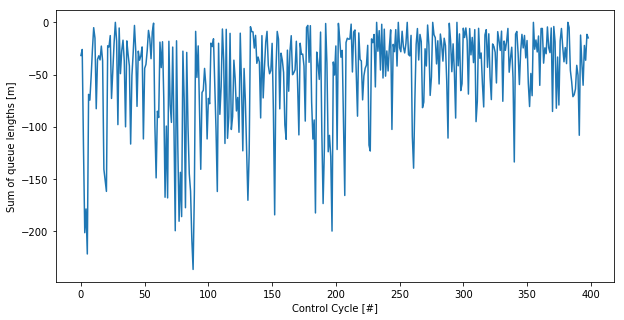

In [125]:
plt.figure(figsize=(10,5))
sum_queues = plt.plot(Learners[0].historic_reward)
plt.xlabel('Control Cycle [#]')
plt.ylabel('Sum of queue lengths [m]')
plt.show()


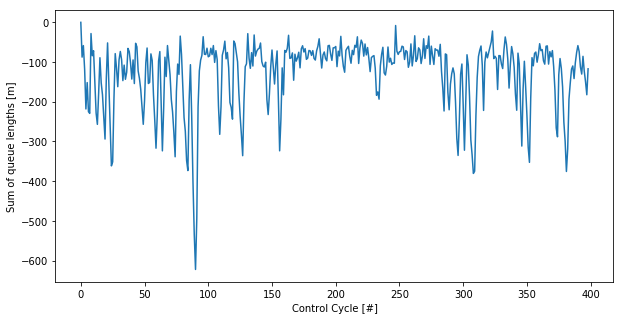

In [222]:
plt.figure(figsize=(10,5))
sum_queues = plt.plot(Learners[0].historic_reward)
plt.xlabel('Control Cycle [#]')
plt.ylabel('Sum of queue lengths [m]')
plt.show()

In [204]:
delay = list()
for i in range(1,4):
    delay.append(Vissim.Net.DelayMeasurements.ItemByKey(i).AttValue('VehDelay(Current,Last,All)'))
for lane in range(len(delay)):
    if delay[lane] == None:
        delay[lane] = 0
delay[0]+delay[1]

0.0